This notebook performs response-weighted analysis on the activation outputs of the Jaco model trained with domain randomisation.

# Initialisation

In [1]:
from rwa import * # custom module for Response-Weighted Analysis

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch.fx

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import math
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

In [2]:
# Define the network - returns the activation maps as outputs
class Network(nn.Module):
    def __init__(self, non_rgb_state_size, num_actions, hidden_size, init_weight_normal, visual_only=False):
        super(Network, self).__init__()
        # Define a flag
        self.visual_only = visual_only
        # Define the conv network
        self.conv1 = nn.Conv2d(3, 16, 8, stride=4, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 5, stride=2)
        if self.visual_only:
            self.fc1 = nn.Linear(1152, hidden_size)
        else:
            self.fc1 = nn.Linear(1152 + non_rgb_state_size, hidden_size)
        self.lstm = nn.LSTMCell(hidden_size, hidden_size)
        # define the network to output the policy
        self.fc_actor1 = nn.Linear(hidden_size, num_actions)
        self.fc_actor2 = nn.Linear(hidden_size, num_actions)
        self.fc_actor3 = nn.Linear(hidden_size, num_actions)
        self.fc_actor4 = nn.Linear(hidden_size, num_actions)
        self.fc_actor5 = nn.Linear(hidden_size, num_actions)
        self.fc_actor6 = nn.Linear(hidden_size, num_actions)
        # define the network to output the value
        self.critic_value = nn.Linear(hidden_size, 1)
        # orthogonal weight initialisation
        for name, p in self.named_parameters():
            if 'weight' in name:
                if init_weight_normal:
                    fan_in, _ = init._calculate_fan_in_and_fan_out(p)
                    std = 1 / math.sqrt(fan_in)
                    init.normal_(p, std=std)
                else:
                    init.orthogonal_(p)
            elif 'bias' in name:
                init.constant_(p, 0)
    
    # define the forward function
    def forward(self, non_rgb_state, rgb_state, h, masks, nenv=None):
        x1 = self.conv1(rgb_state / 255.0)
        x = F.relu(x1)
        x2 = self.conv2(x)
        x = F.relu(x2)
        x = x.view(x.size(0), -1)
        if self.visual_only:
            x = self.fc1(x)
        else:
            x = self.fc1(torch.cat((x, non_rgb_state), 1))
        if nenv is None:
            hx, cx = h
            hx = hx * masks
            cx = cx * masks
            h = self.lstm(x, (hx, cx))
            x = h[0]
        else:
            hxs, cxs = h
            envstartidx = np.arange(0, rgb_state.size(0), rgb_state.size(0) / nenv)
            x = x.view(-1, 1, x.size(1))
            masks = masks.view(-1, 1, masks.size(1))
            outputs = []
            for idx in range(rgb_state.size(0)):
                if idx in envstartidx:
                    hx = hxs[idx].unsqueeze(0)
                    cx = cxs[idx].unsqueeze(0)
                hx = hx * masks[idx]
                cx = cx * masks[idx]
                hx, cx = self.lstm(x[idx], (hx, cx))
                outputs.append(hx)
            x = torch.cat(outputs, 0)
            
        # get the alpha and beta for the beta distribution; the policy is *stochastic*
        policy1 = F.softmax(self.fc_actor1(x), dim=1).clamp(max=1 - 1e-20)
        policy2 = F.softmax(self.fc_actor2(x), dim=1).clamp(max=1 - 1e-20)
        policy3 = F.softmax(self.fc_actor3(x), dim=1).clamp(max=1 - 1e-20)
        policy4 = F.softmax(self.fc_actor4(x), dim=1).clamp(max=1 - 1e-20)
        policy5 = F.softmax(self.fc_actor5(x), dim=1).clamp(max=1 - 1e-20)
        policy6 = F.softmax(self.fc_actor6(x), dim=1).clamp(max=1 - 1e-20) 
        pi = (policy1, policy2, policy3, policy4, policy5, policy6)
        # get the state value
        value = self.critic_value(x)

        return x1, x2, h 

In [3]:
# Define the network and the trained model
# visual only - no proprioception; agent learns a policy based on visual input only
net = Network(num_actions=5, non_rgb_state_size=0, hidden_size=128, init_weight_normal=1, visual_only=True)

# load trained model
model_filename = './model_data/jaco_model/visual_random/seed_5/model.pt'
net.load_state_dict(torch.load(model_filename, map_location=torch.device('cpu')))

<All keys matched successfully>

# Weights Visualisation

Weights of Conv1 only - serve as a sanity check of the RWA method.

In [4]:
# information of the network
print(net)
print(net.state_dict().keys())

Network(
  (conv1): Conv2d(3, 16, kernel_size=(8, 8), stride=(4, 4), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (lstm): LSTMCell(128, 128)
  (fc_actor1): Linear(in_features=128, out_features=5, bias=True)
  (fc_actor2): Linear(in_features=128, out_features=5, bias=True)
  (fc_actor3): Linear(in_features=128, out_features=5, bias=True)
  (fc_actor4): Linear(in_features=128, out_features=5, bias=True)
  (fc_actor5): Linear(in_features=128, out_features=5, bias=True)
  (fc_actor6): Linear(in_features=128, out_features=5, bias=True)
  (critic_value): Linear(in_features=128, out_features=1, bias=True)
)
odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'lstm.weight_ih', 'lstm.weight_hh', 'lstm.bias_ih', 'lstm.bias_hh', 'fc_actor1.weight', 'fc_actor1.bias', 'fc_actor2.weight', 'fc_actor2.bias', 'fc_actor3.weight', 'fc_actor3.bias', 'fc_actor4.weig

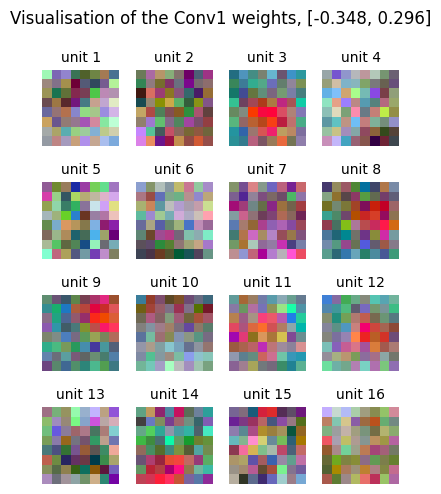

In [5]:
# conv1 weights (kernels) visualisation - 16 units
w1 = net.state_dict()['conv1.weight']
w1 = np.transpose(w1, (0, 2, 3, 1)) # transform to visualisation format in rgb state

# visualise the weights as RGB images
for i in range(w1.shape[0]): # loop through each unit
    plt.subplot(4, 4, i+1)
    plt.axis('off')
    to_show = (w1[i] - w1[i].min()) / (w1[i].max() - w1[i].min()) # normalise to [0, 1]
    plt.imshow(to_show)
    plt.title(f'unit {str(i+1)}', fontsize=10)
plt.suptitle(f'Visualisation of the Conv1 weights, {[np.round(float(w1.min()), 3), np.round(float(w1.max()), 3)]}')
plt.tight_layout()
plt.gcf().set_size_inches(4, 5)
plt.show()

# Lab Recording Room

Where you collect neural responses

In [6]:
# experiment settings
batch_num = 50
batch_size = 1000
zero_mean = True
layer = 'conv1'

In [14]:
act_conv1, noise1 = JacoActRecorder(layer, net, batch_num=batch_num, batch_size=batch_size, zero_mean=zero_mean)
print(noise1.min(), noise1.max(), noise1.mean())

100%|██████████| 50/50 [00:09<00:00,  5.03it/s]


Activation recording completed


100%|██████████| 16/16 [00:00<00:00, 736.03it/s]


Shape of activation response list: torch.Size([16, 50000])
Shape of noise list: torch.Size([50000, 64, 64, 3])
tensor(-127.5000) tensor(127.5000) tensor(-0.0001)


In [15]:
# save the activation and noise data
torch.save(act_conv1, './rwa_data/jaco/jaco_rand_0mean/act1.pt')
torch.save(noise1, './rwa_data/jaco/jaco_rand_0mean/noise1.pt')

# Conv1 - Zero Mean [-127.5, 127,5]

The noise input follows the requirements of STA - zero mean, symmetric noise distribution for unbiased estimation. \
However, it is important to note that the model never received negative inputs during training (since image data).

In [10]:
# load existing data if already recorded
batch_num = 50
batch_size = 1000
zero_mean = True
layer = 'conv1'

act_conv1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/act1.pt')
noise1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/noise1.pt')
rf1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf1.pt')
rf_corr1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf_corr1.pt')
correlation1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/correlation1.pt')
rf_cropped1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf_cropped1.pt')
noise_cropped1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/noise_cropped1.pt')
# cov1 = torch.load('./rwa_data/jaco/jaco_rand_0mean/cov1.pt')
# cov1_ = torch.load('./rwa_data/jaco/jaco_rand_0mean/cov1_.pt')
# rf_cropped1_ = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf_cropped1_.pt')
# noise_cropped1_ = torch.load('./rwa_data/jaco/jaco_rand_0mean/noise_cropped1_.pt')

# # load eigen1.pkl
# with open('./rwa_data/jaco/jaco_rand_0mean/eigen1.pkl', 'rb') as f:
#     eigen1 = pickle.load(f)

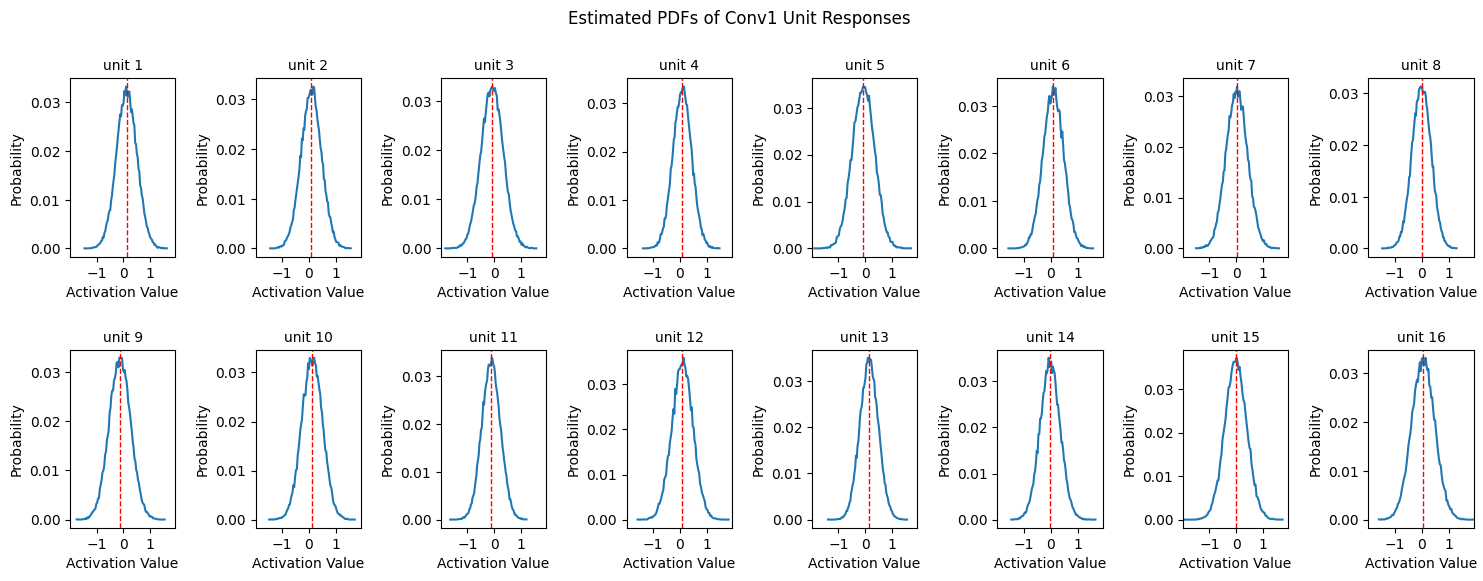

In [11]:
# PDFs of conv1 responses
for i in range(act_conv1.shape[0]):
    # plot initialisation
    plt.subplot(2, 8, i+1)
    plt.xlim(act_conv1.min(), act_conv1.max())
    
    # plot the PDF of the activation values
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv1[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf)
        plt.xlabel('Activation Value')
        plt.ylabel('Probability')
        plt.axvline(act_conv1[i].mean(), color='red', linestyle='dashed', linewidth=1)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(14, 5)

plt.suptitle('Estimated PDFs of Conv1 Unit Responses')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 6)
plt.show()

Receptive Field Estimation via Response-Weighted Average

In [17]:
# RWA - unbiased RF estimation
rf1 = RWA(act_conv1, noise1)

  0%|          | 256/800000 [00:00<05:15, 2537.14it/s]

100%|██████████| 800000/800000 [01:34<00:00, 8439.97it/s]

Shape of receptive field list: torch.Size([16, 64, 64, 3])


In [18]:
# Save the RWA data
torch.save(rf1, './rwa_data/jaco/jaco_rand_0mean/rf1.pt')

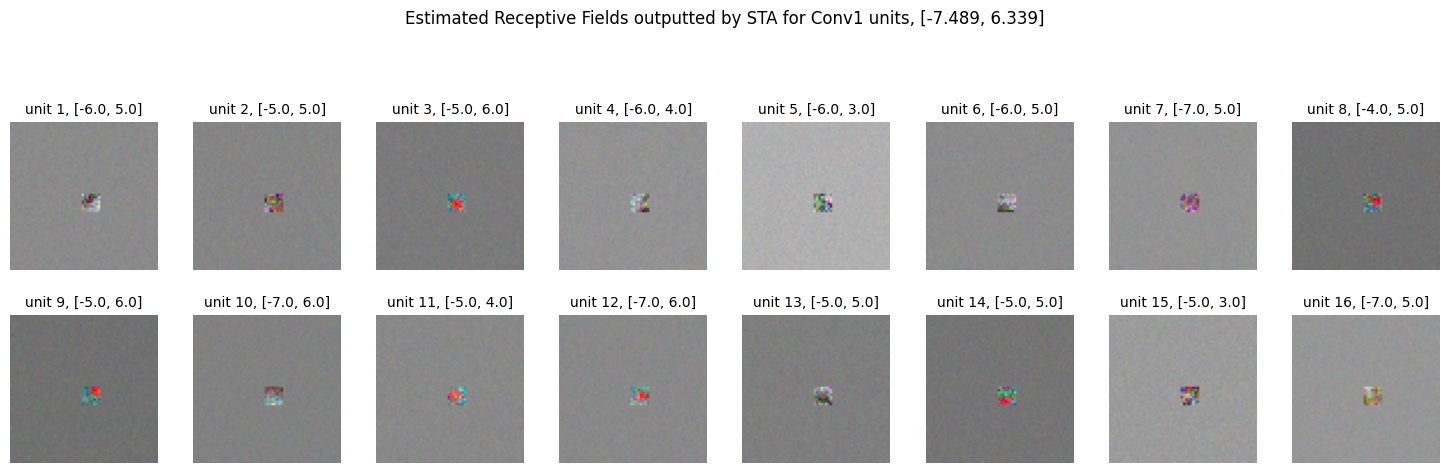

In [9]:
# Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(2, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}, [{np.round(rf1[i].min())}, {np.round(rf1[i].max())}]', fontsize=10)
    

# title for the entire plot
plt.suptitle(f'Estimated Receptive Fields outputted by STA for Conv1 units, {[np.round(float(rf1.min()), 3), np.round(float(rf1.max()), 3)]}')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5.5)
plt.show()

Receptive Field Estimation via Pearson Correlation

In [37]:
# gets the correlation between the RF and the noise for each unit
rf_corr1 = torch.zeros(rf1.shape)
for i in range(rf1.shape[3]):
    rf_corr1[:, :, :, i] = CorrRWA(act_conv1, noise1[:, :, :, i])

  0%|          | 0/65536 [00:00<?, ?it/s]

100%|██████████| 65536/65536 [03:30<00:00, 310.82it/s]


In [38]:
# Save the RWA data
torch.save(rf_corr1, './rwa_data/jaco/jaco_rand_0mean/rf_corr1.pt')

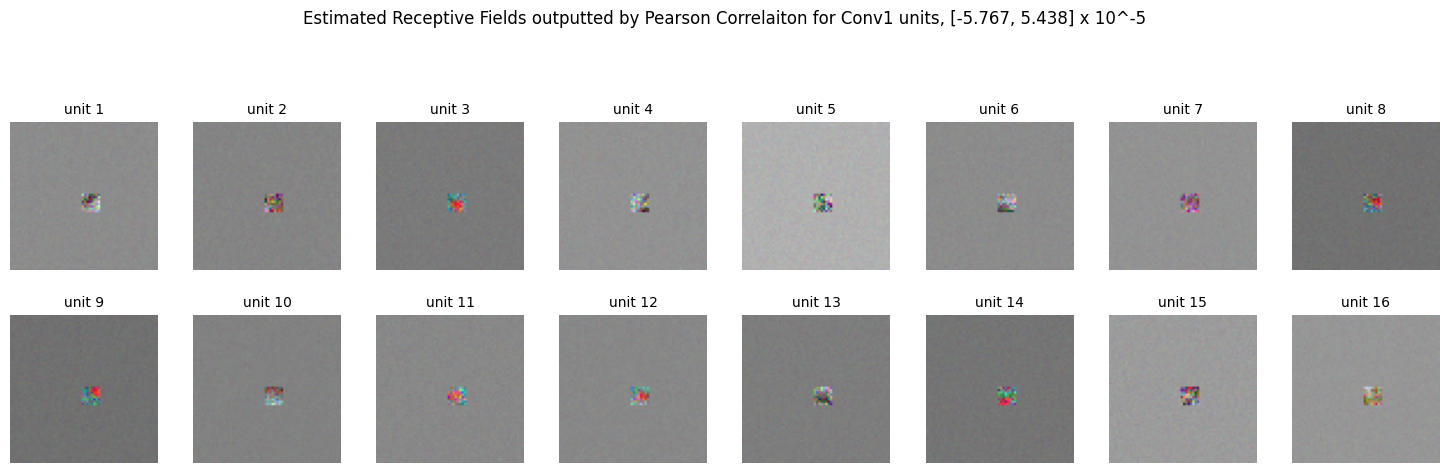

In [10]:
# Visualise the RWA output as image plots
for i in range(rf_corr1.shape[0]):
    plt.subplot(2, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_corr1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=10)

# title for the entire plot
plt.suptitle(f'Estimated Receptive Fields outputted by Pearson Correlaiton for Conv1 units, {[np.round(float(rf_corr1.min())*10**5, 3), np.round(float(rf_corr1.max()*10**5), 3)]} x 10^-5')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5.5)
plt.show()

RF Cropping via Pearson Correlation Mask

In [53]:
# calculate the Pearson correlation between the RFs and the input noise and accumulate to obtain mask for cropping
correlation1 = torch.zeros(rf1.shape[1], rf1.shape[2], rf1.shape[3])
for i in range(rf1.shape[3]):
    correlation1[:, :, i] = CorrLoc(noise1[:, :, :, i], act_conv1)

100%|██████████| 65536/65536 [03:40<00:00, 297.16it/s]


In [54]:
# save the correlation data
torch.save(correlation1, './rwa_data/jaco/jaco_rand_0mean/correlation1.pt')

In [55]:
# crop the RFs
rf_cropped1 = []
for i in range(rf1.shape[3]):
    tmp, _ = RfCrop(correlation1[:, :, i], rf_corr1[:, :, :, i])
    rf_cropped1.append(tmp)
rf_cropped1 = torch.stack(rf_cropped1, dim=3)

In [56]:
# save the cropped RFs
torch.save(rf_cropped1, './rwa_data/jaco/jaco_rand_0mean/rf_cropped1.pt')

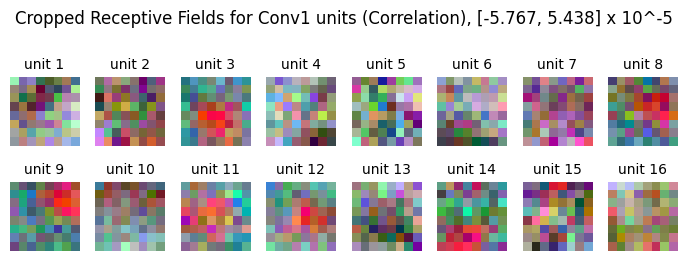

In [11]:
# display cropped RFs
for i in range(rf_cropped1.shape[0]):
    plt.subplot(2, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_cropped1[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle(f'Cropped Receptive Fields for Conv1 units (Correlation), {[np.round(float(rf_cropped1.min())*10**5, 3), np.round(float(rf_cropped1.max()*10**5), 3)]} x 10^-5')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(7, 3)
plt.show()

Response-Weighted Covariance

In [12]:
# crop noise to the same dimensions as the cropped RFs
noise_cropped1 = torch.zeros(noise1.shape[0], rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
for i in range(noise_cropped1.shape[3]):
    tmp, _ = RfCrop(correlation1[:, :, i], noise1[:, :, :, i])
    noise_cropped1[:, :, :, i] = tmp
print(noise_cropped1.shape)

torch.Size([50000, 8, 8, 3])


In [13]:
torch.save(noise_cropped1, './rwa_data/jaco/jaco_rand_0mean/noise_cropped1.pt')

In [16]:
# unravel noise and RFs for RWC
noise_cropped1_ = noise_cropped1.view(noise_cropped1.shape[0], -1) # 50000, 8*8*3=192
rf_cropped1_ = rf_cropped1.view(rf_cropped1.shape[0], -1) # 16, 8*8*3=192

In [19]:
cov1 = RWC(act_conv1, noise_cropped1_, rf_cropped1_, zero_mean=zero_mean)
print(cov1.shape)

100%|██████████| 800000/800000 [03:57<00:00, 3363.50it/s]

torch.Size([16, 192, 192])


In [20]:
# save the pca covariance data
torch.save(rf_cropped1_, './rwa_data/jaco/jaco_rand_0mean/rf_cropped1_.pt')
torch.save(noise_cropped1_, './rwa_data/jaco/jaco_rand_0mean/noise_cropped1_.pt')
torch.save(cov1, './rwa_data/jaco/jaco_rand_0mean/cov1.pt')

In [100]:
# Principal Component Analysis
pca = PCA()
eigenvectors_min1 = [[] for i in range(cov1.shape[0])]
eigenvectors_max1 = [[] for i in range(cov1.shape[0])]
eigenvalues1 = [[] for i in range(cov1.shape[0])]

for i in range(cov1.shape[0]):
    pca.fit(cov1[i])
    eigenvectors_min1[i] = pca.components_[-1]
    eigenvectors_max1[i] = pca.components_[0]
    eigenvalues1[i] = pca.explained_variance_ratio_

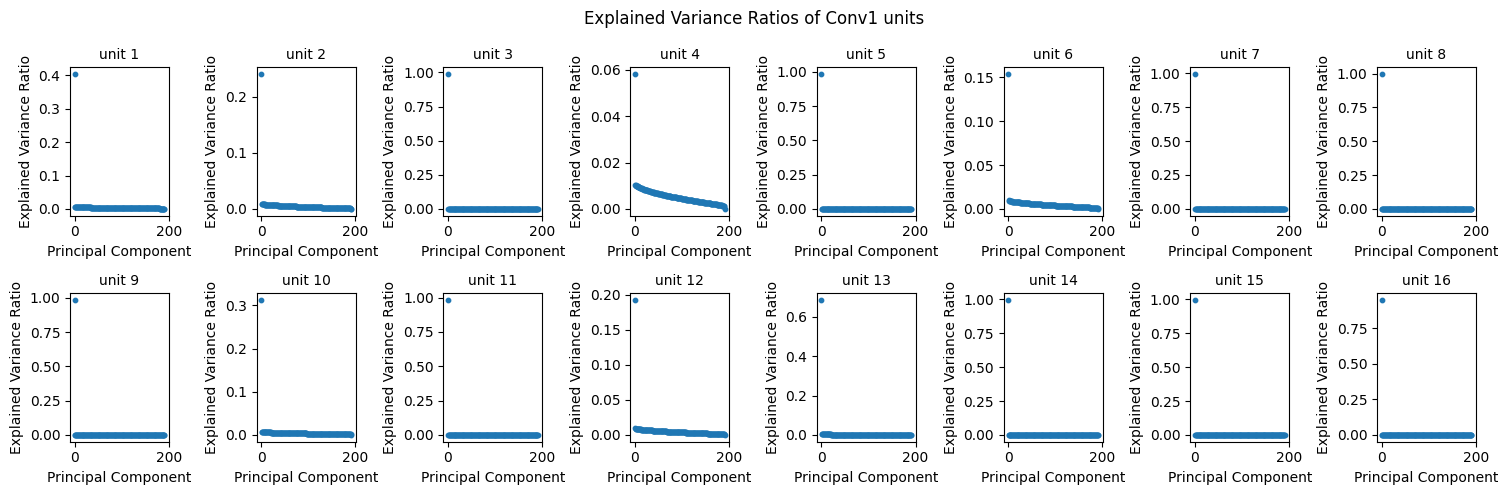

In [98]:
# visualise the eigenvalues
for i in range(cov1.shape[0]):
    plt.subplot(2, 8, i+1)
    plt.scatter(range(len(eigenvalues1[i])), eigenvalues1[i], s=10)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(15, 5)
plt.suptitle('Explained Variance Ratios of Conv1 units') 
plt.tight_layout()
plt.gcf().set_size_inches(15, 5)
plt.show()

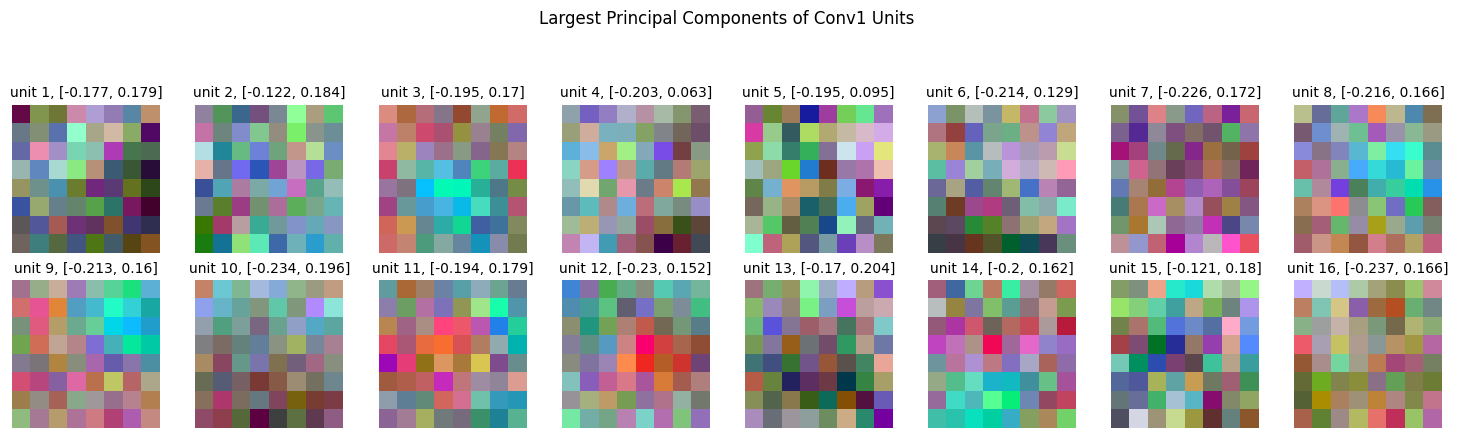

In [102]:
# Principal Components
for i in range(cov1.shape[0]):
    plt.subplot(2, 8, i+1)
    plt.axis('off')
    x = eigenvectors_max1[i].reshape(rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
    to_show = (x - x.min()) / (x.max() - x.min())
    plt.imshow(to_show)
    plt.title(f'unit {str(i+1)}, {[np.round(x.min(),3), np.round(x.max(),3)]}', fontsize=10)

plt.suptitle('Largest Principal Components of Conv1 Units') 
plt.tight_layout()
plt.gcf().set_size_inches(15, 5)
plt.show()

In [118]:
print(noise_cropped1_.shape)
print(eigenvectors_max1[0].shape)

torch.Size([50000, 192])
(192,)


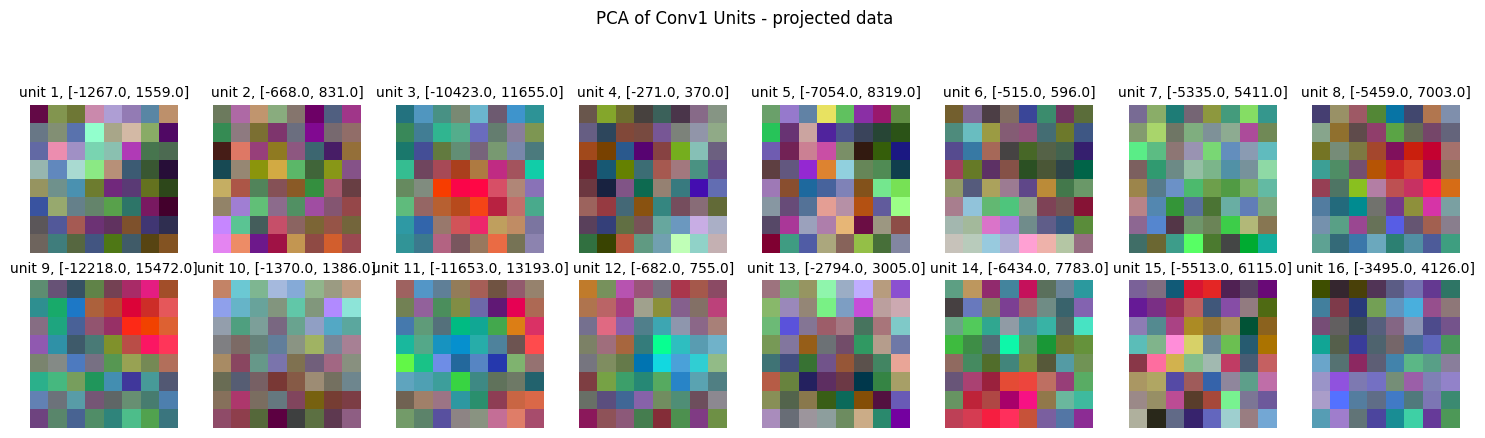

In [76]:
# Project the data onto the first principal component
for i in range(cov1.shape[0]):
    plt.subplot(2, 8, i+1)
    plt.axis('off')
    x = noise_cropped1_[i] @ eigenvectors_max1[i]
    plt.imshow(to_show)
    plt.title(f'unit {str(i+1)}, {[np.round(x.min()), np.round(x.max())]}', fontsize=10)

plt.suptitle('PCA of Conv1 Units - projected data') 
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5)
plt.show()

In [86]:
# fixing PCA
# initialisations
num_units = act_conv1.shape[0]
input = torch.zeros(num_units, noise_cropped1.shape[1]*noise_cropped1.shape[2]*noise_cropped1.shape[3])

# reformat rf data to fit with noise
if zero_mean:
    rf = ((rf_cropped1 - rf_cropped1.min()) / (rf_cropped1.max() - rf_cropped1.min()) - 0.5) * 255 # normalise to [-127.5, 127.5]
else:
    rf = (rf_cropped1 - rf_cropped1.min()) / (rf_cropped1.max() - rf_cropped1.min()) * 255 # normalise to [0, 255]
# reshape the rf and noise for analysis
rf = rf.reshape(num_units, -1)
noise = noise_cropped1.reshape(noise_cropped1.shape[0], -1)

# calculate the response-weighted covariance
with tqdm(total = num_units * noise.shape[0]) as pbar:
    for i in range(num_units):
        mu = noise - rf[i]
        count = 0
        for j in range(noise.shape[0]):
            input[i] += math.sqrt(abs(act_conv1[i, j])) * mu[j]
            if act_conv1[i, j] != 0:
                count += 1
            pbar.update(1)
        input[i] /= count

  0%|          | 0/800000 [00:00<?, ?it/s]

100%|██████████| 800000/800000 [00:44<00:00, 17919.38it/s]


# Conv1 - Positive Only [0, 255]

In [ ]:
# load existing data if already recorded
act_conv1 = torch.load('./rwa_data/jaco/jaco_rand/act1.pt')
noise1 = torch.load('./rwa_data/jaco/jaco_rand/noise1.pt')
rf1 = torch.load('./rwa_data/jaco/jaco_rand/rf1.pt')

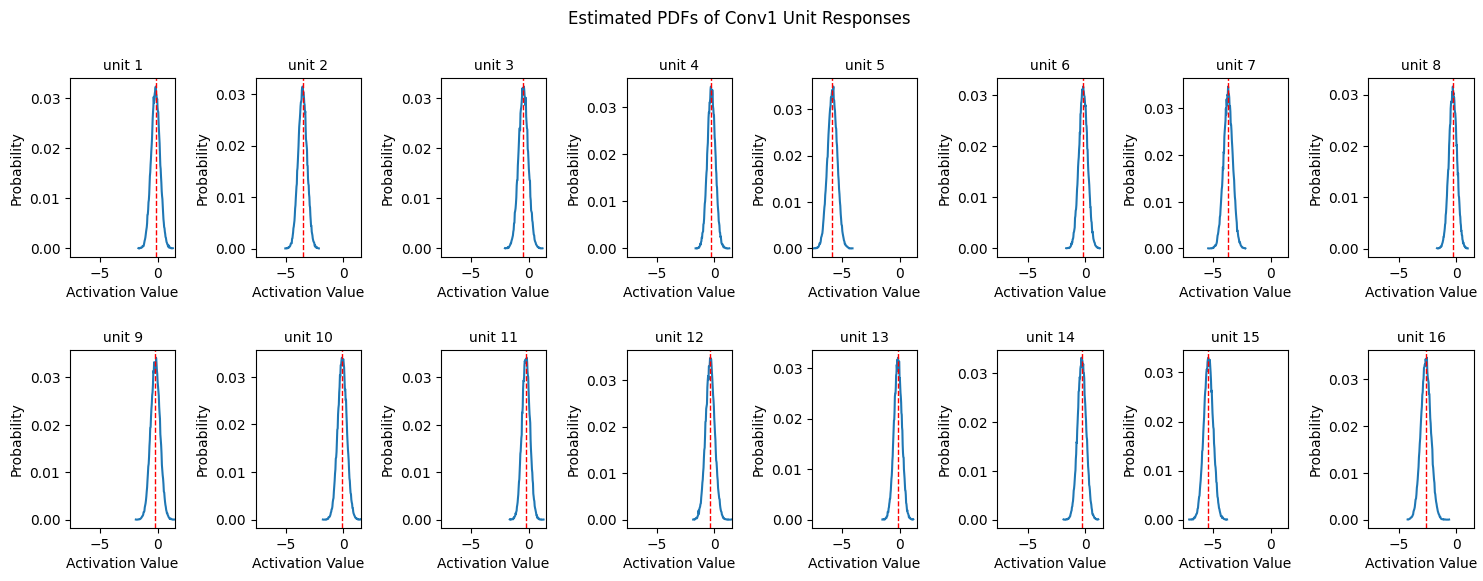

In [18]:
# PDFs of conv1 responses
for i in range(act_conv1.shape[0]):
    plt.subplot(2, 8, i+1)
    plt.xlim(act_conv1.min(), act_conv1.max())
    
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv1[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf)
        plt.xlabel('Activation Value')
        plt.ylabel('Probability')
        plt.axvline(act_conv1[i].mean(), color='red', linestyle='dashed', linewidth=1)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(14, 5)

plt.suptitle('Estimated PDFs of Conv1 Unit Responses')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 6)
plt.show()

RWA

In [20]:
# RWA
rf1 = RWA(act_conv1, noise1)

100%|██████████| 800000/800000 [01:06<00:00, 11960.78it/s]


Shape of receptive field list: torch.Size([16, 64, 64, 3])


In [21]:
# Save the RWA data
torch.save(rf1, './rwa_data/jaco/jaco_rand/rf1.pt')

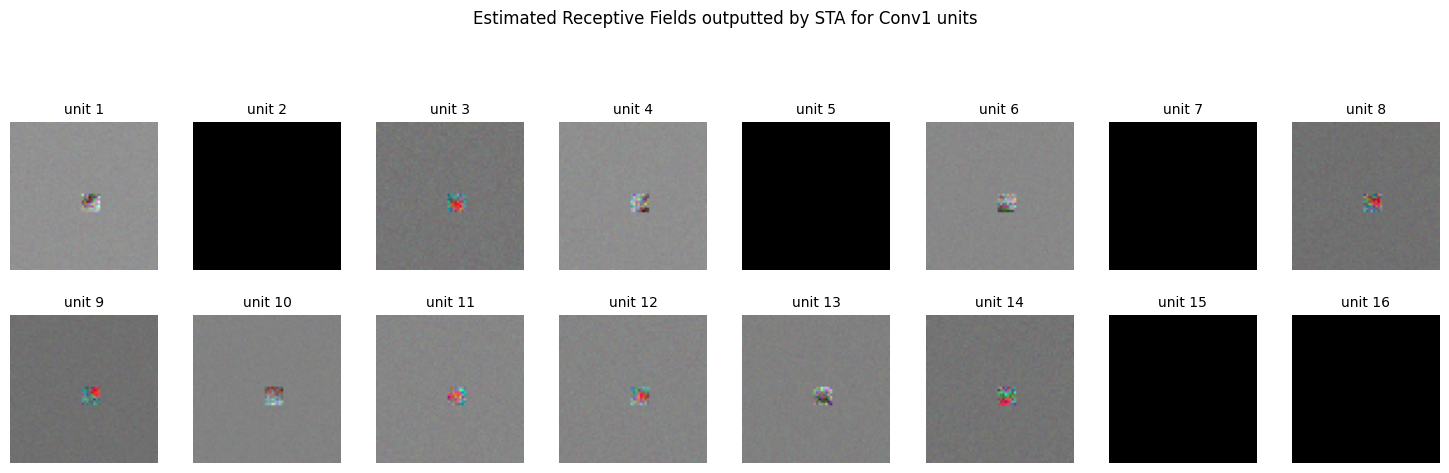

In [22]:
# Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(2, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf1[i]
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0:
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Estimated Receptive Fields outputted by STA for Conv1 units')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5.5)
plt.show()

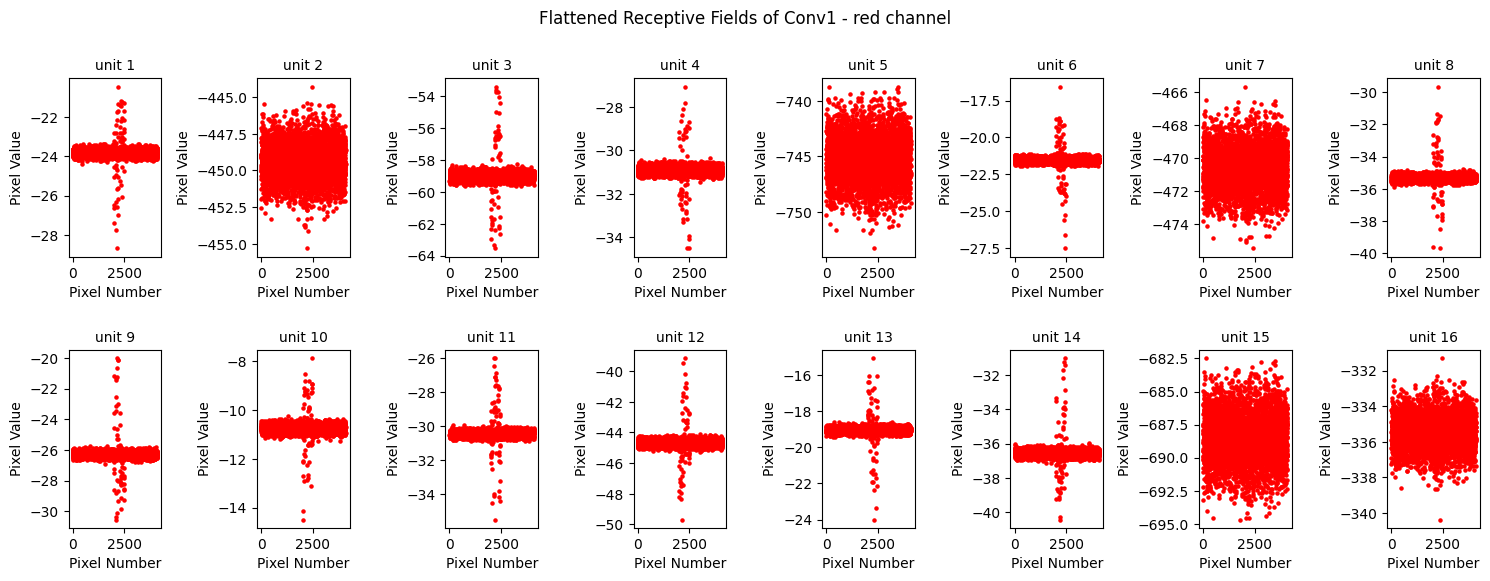

In [24]:
# Flattened RWA Visualisation
channel = 0
color = ['red', 'green', 'blue']

for i in range(rf1.shape[0]):
    plt.subplot(2, 8, i+1) # nrows, ncols, index
    plt.xlabel('Pixel Number')
    plt.ylabel('Pixel Value')
    to_show = rf1[i, :, :, channel]
    if to_show.any() != 0:
        to_show = to_show.flatten() # flatten the receptive field into 1 x 4096
        plt.scatter(range(len(to_show)), to_show, s=5, c=color[channel])
        plt.gcf().set_size_inches(15, 5)
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)

plt.suptitle(f'Flattened Receptive Fields of Conv1 - {color[channel]} channel')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 6)
plt.show()

RWC

In [ ]:
# load existing data if already recorded
cov1 = torch.load('./rwa_data/jaco/jaco_rand/cov1.pt')
eigen1 = torch.load('./rwa_data/jaco/jaco_rand/eigen1.pt')

In [ ]:
# RWC
cov1 = RWC(layer, net, act_conv1, noise1, rf1, NBatches=NBatches, BSize=BSize, zeroMean=zeroMean, absolute=True)

In [ ]:
torch.save(cov1, './rwa_data/jaco/jaco_rand/cov1.pt')

In [ ]:
# eigen analysis - conv1
NUnits = cov1.shape[0]
eigen1 = []
with tqdm(total=NUnits) as pbar:
    for i in range(NUnits):
        eigen1.append(eigenAnalysis(cov1, i))
        pbar.update(1)

In [ ]:
# save the eigenvalues and eigenvectors
with open('./rwa_data/jaco/jaco_rand/eigen1.pkl', 'wb') as f:
    pickle.dump(eigen1, f)

In [ ]:
# conv1 eigenvalues

# plot the eigenvalues for each unit - all eigenvalues
for i in range(len(eigen1)): # each unit
    plt.subplot(2, 8, i+1)
    
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if list is not empty
        # plot the eigenvalues for red (first) channel only
        eigenvalues = eigen1[i][0].eigenvalues
        eigenvalues = (eigenvalues - eigenvalues.min()) / (eigenvalues.max() - eigenvalues.min()) # normalise to [0, 1]
        plt.scatter(range(len(eigenvalues)), eigenvalues, s=10)
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.xlabel('Eigenvalue Index')
        plt.ylabel('Normalised Eigenvalue')
        # change figure size
        plt.gcf().set_size_inches(13, 5)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        # turn off axis
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
plt.suptitle('Eigen Analysis of Conv1 units')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5)
plt.show()

# plot the eigenvalues for each unit - excludes the largest eigenvalue
plt.figure()
for i in range(len(eigen1)): # each unit
    plt.subplot(2, 8, i+1)
    
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if list is not empty
        # plot the eigenvalues for red (first) channel only
        eigenvalues = eigen1[i][1].eigenvalues
        eigenvalues = (eigenvalues - eigenvalues.min()) / (eigenvalues.max() - eigenvalues.min()) # normalise to [0, 1]
        plt.scatter(range(len(eigenvalues)-1), eigenvalues[:-1], s=10)
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.xlabel('Eigenvalue Index')
        plt.ylabel('Normalised Eigenvalue')
        # change figure size
        plt.gcf().set_size_inches(13, 5)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        # turn off axis
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
plt.suptitle('Eigen Analysis of Conv1 units - excludes the largest eigenvalue')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5)

# plot the eigenvalues for each unit - excludes the smallest eigenvalue
plt.figure()
for i in range(len(eigen1)): # each unit
    plt.subplot(2, 8, i+1)
    
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if list is not empty
        # plot the eigenvalues for red (first) channel only
        eigenvalues = eigen1[i][0].eigenvalues
        eigenvalues = (eigenvalues - eigenvalues.min()) / (eigenvalues.max() - eigenvalues.min()) # normalise to [0, 1]
        plt.scatter(range(len(eigenvalues)-1), eigenvalues[1:], s=10)
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.xlabel('Eigenvalue Index')
        plt.ylabel('Normalised Eigenvalue')
        # change figure size
        plt.gcf().set_size_inches(13, 5)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        # turn off axis
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
plt.suptitle('Eigen Analysis of Conv1 units - excludes the smallest eigenvalue')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5)

In [ ]:
# eigenvectors visualisation - conv1 LARGEST
for i in range(len(eigen1)): # each unit
    to_show = torch.zeros(64, 64, 3)
    plt.subplot(2, 8, i+1)
    plt.axis('off')
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0:
        for j in range(3): # append each channel
            eigenvector = eigen1[i][j].eigenvectors # given channel for a given unit
            # eigenvector = eigenvector * eigen1[i][j].eigenvalues
            to_show[:, :, j] = eigenvector[:, -1].reshape(64, 64) # select the eigenvector with the largest eigenvalue
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min())
        plt.imshow(to_show) # normalise to [0, 1]
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)

plt.suptitle('Eigen Analysis of Conv1 units - eigenvectors with the largest eigenvalues') 
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5)
plt.show()

# eigenvectors visualisation - conv1 SMALLEST
for i in range(len(eigen1)): # each unit
    to_show = torch.zeros(64, 64, 3)
    plt.subplot(2, 8, i+1)
    plt.axis('off')
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0:
        for j in range(3): # append each channel
            eigenvector = eigen1[i][j].eigenvectors # given channel for a given unit
            # eigenvector = eigenvector * eigen1[i][j].eigenvalues
            to_show[:, :, j] = eigenvector[:, 0].reshape(64, 64) # select the eigenvector with the largest eigenvalue
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min())
        plt.imshow(to_show) # normalise to [0, 1]
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)

plt.suptitle('Eigen Analysis of Conv1 units - eigenvectors with the smallest eigenvalues') 
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 5)
plt.show()

# Conv2 - Zero Mean [-127.5, 127,5]

In [ ]:
# load existing data if already recorded
act_conv2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/act2.pt')
noise2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/noise2.pt')
rf2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf2.pt')
rf_corr2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf_corr2.pt')
correlation2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/correlation2.pt')
rf_cropped2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/rf_cropped2.pt')
noise_cropped2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/noise_cropped2.pt')
cov2 = torch.load('./rwa_data/jaco/jaco_rand_0mean/cov2.pt')
cov2_ = torch.load('./rwa_data/jaco/jaco_rand_0mean/cov2_.pt')

# load eigen1.pkl
with open('./rwa_data/jaco/jaco_rand_0mean/eigen2.pkl', 'rb') as f:
    eigen2 = pickle.load(f)

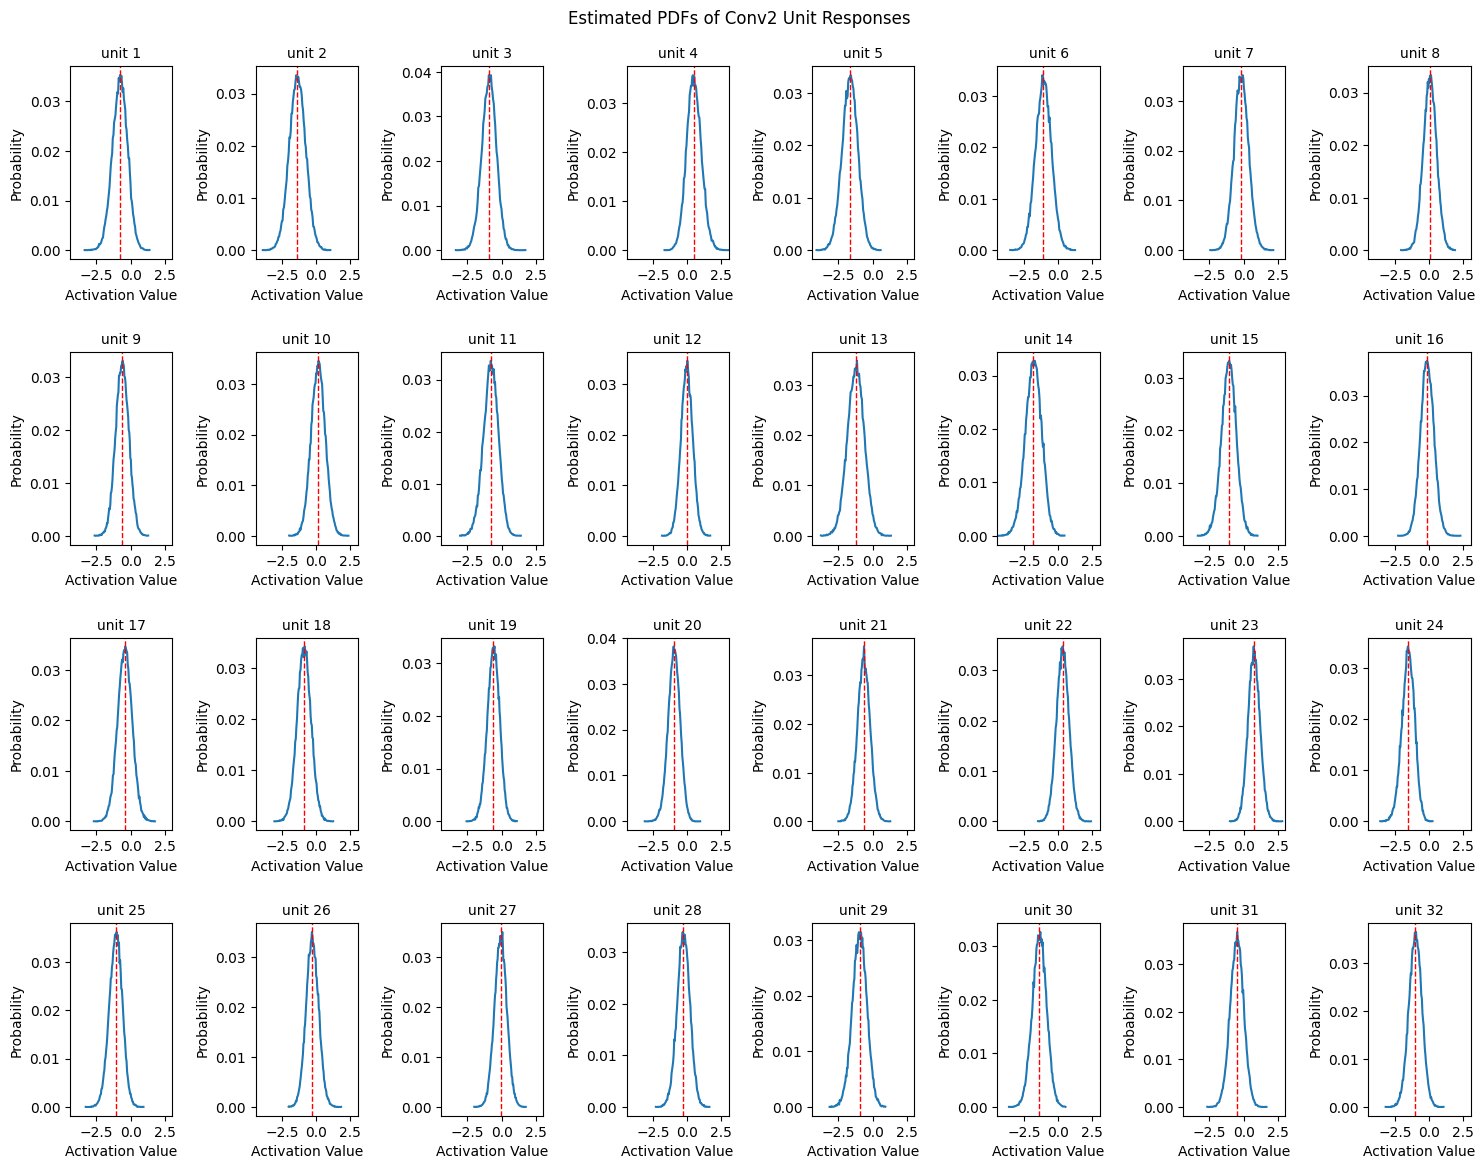

In [102]:
# PDFs of conv2 responses
for i in range(act_conv2.shape[0]):
    # plot initialisation
    plt.subplot(4, 8, i+1)
    plt.xlim(act_conv2.min(), act_conv2.max())
    
    # plot the PDF of the activation values
    if act_conv2[i][act_conv2[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv2[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf)
        plt.xlabel('Activation Value')
        plt.ylabel('Probability')
        plt.axvline(act_conv2[i].mean(), color='red', linestyle='dashed', linewidth=1)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(14, 10)

plt.suptitle('Estimated PDFs of Conv2 Unit Responses')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 12)
plt.show()

Receptive Field Estimation via Response-Weighted Average

In [103]:
# RWA
rf2 = RWA(act_conv2, noise2)

100%|██████████| 1600000/1600000 [02:30<00:00, 10642.17it/s]

Shape of receptive field list: torch.Size([32, 64, 64, 3])


In [105]:
# Save the RWA data
torch.save(rf2, './rwa_data/jaco/jaco_rand_0mean/rf2.pt')

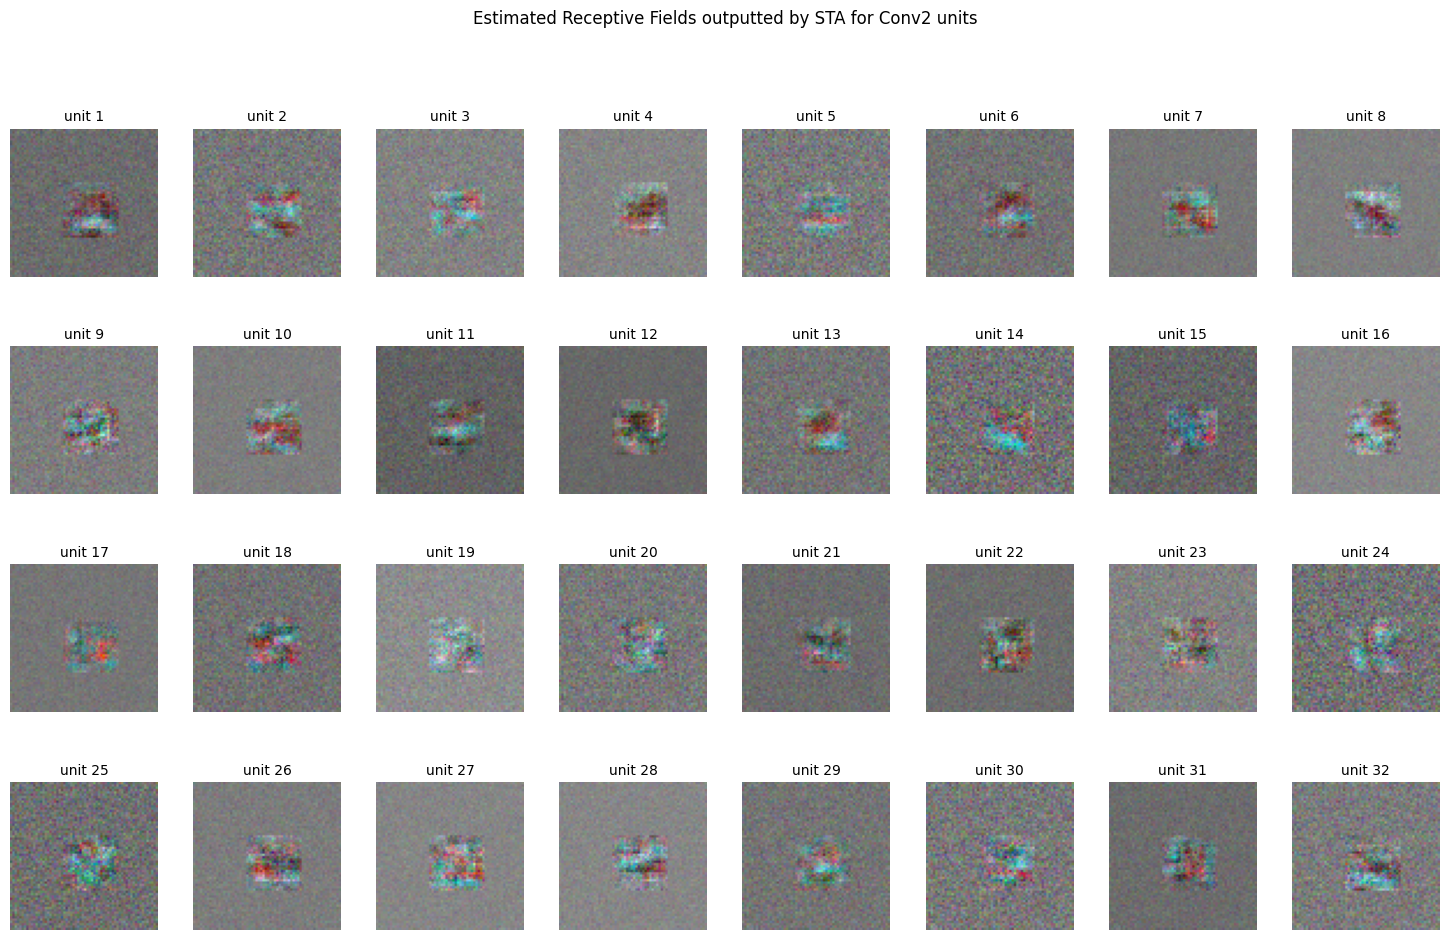

In [106]:
# Visualise the RWA output as image plots
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf2[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Estimated Receptive Fields outputted by STA for Conv2 units')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 10)
plt.show()

Receptive Field Estimation via Pearson Correlation

In [107]:
rf_corr2 = torch.zeros(rf2.shape)
for i in range(rf2.shape[3]):
    rf_corr2[:, :, :, i] = CorrRWA(act_conv2, noise2[:, :, :, i])

  0%|          | 0/131072 [00:00<?, ?it/s]

100%|██████████| 131072/131072 [03:54<00:00, 559.05it/s]


In [109]:
# Save the RWA data
torch.save(rf_corr2, './rwa_data/jaco/jaco_rand_0mean/rf_corr2.pt')

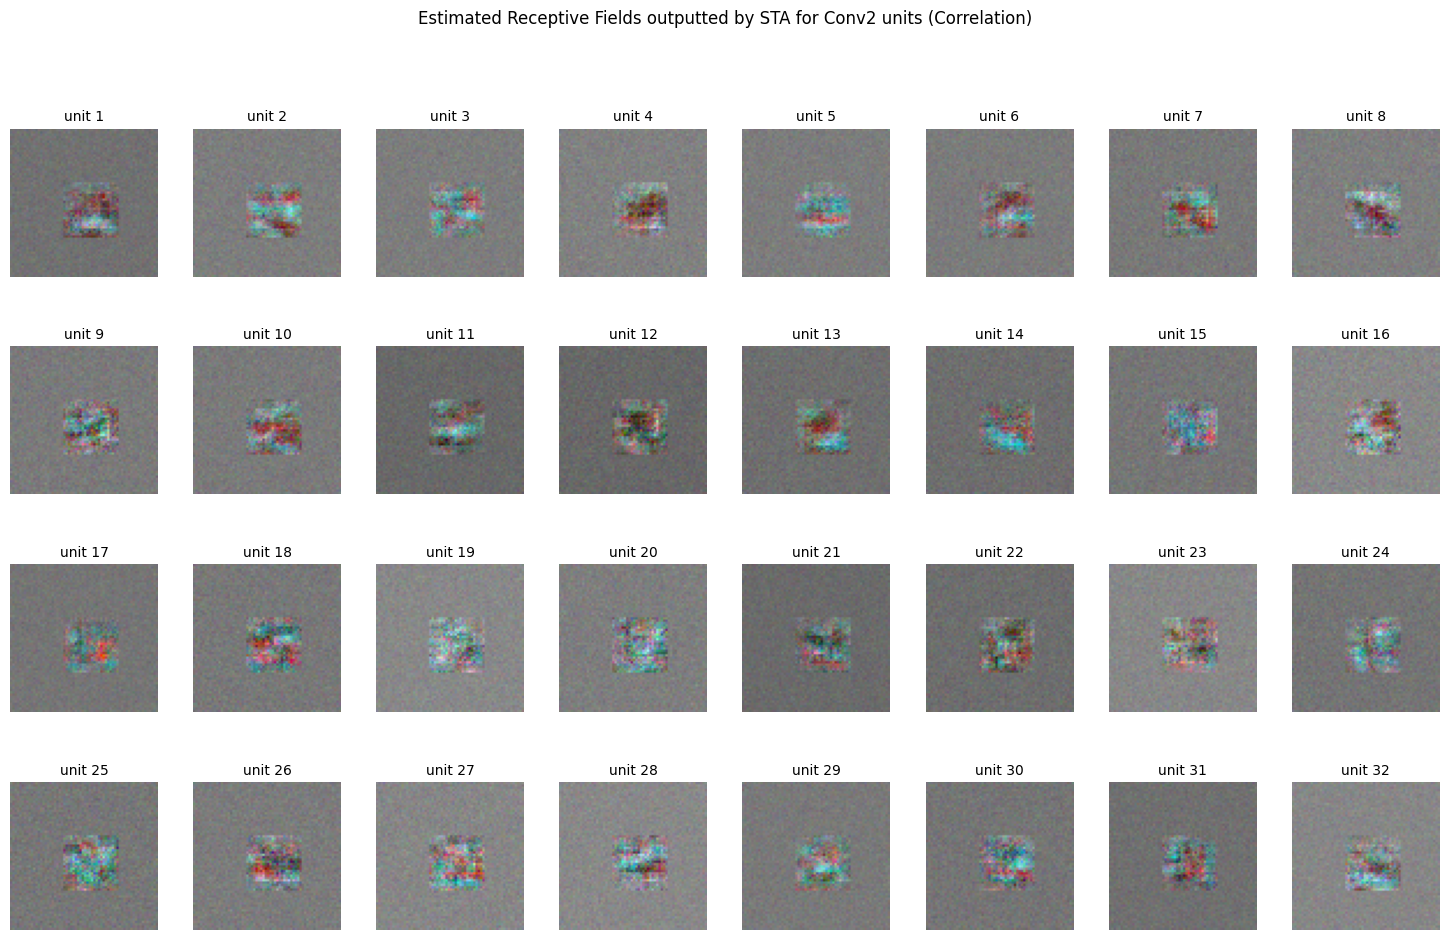

In [110]:
# Visualise the RWA output as image plots
for i in range(rf_corr2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_corr2[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Estimated Receptive Fields outputted by STA for Conv2 units (Correlation)')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 10)
plt.show()

Correlation

In [111]:
# calculate the Pearson correlation between the RFs and the input noise
correlation2 = torch.zeros(rf2.shape[1], rf2.shape[2], rf2.shape[3])
for i in range(rf2.shape[3]):
    correlation2[:, :, i] = CorrLoc(noise2[:, :, :, i], act_conv2)

100%|██████████| 131072/131072 [04:01<00:00, 542.70it/s]


In [112]:
# save the correlation data
torch.save(correlation2, './rwa_data/jaco/jaco_rand_0mean/correlation2.pt')

In [113]:
# crop the RFs
rf_cropped2 = []
for i in range(rf2.shape[3]):
    tmp, _ = RfCrop(correlation2[:, :, i], rf2[:, :, :, i])
    rf_cropped2.append(tmp)
rf_cropped2 = torch.stack(rf_cropped2, dim=3)

In [114]:
# save the cropped RFs
torch.save(rf_cropped2, './rwa_data/jaco/jaco_rand_0mean/rf_cropped2.pt')

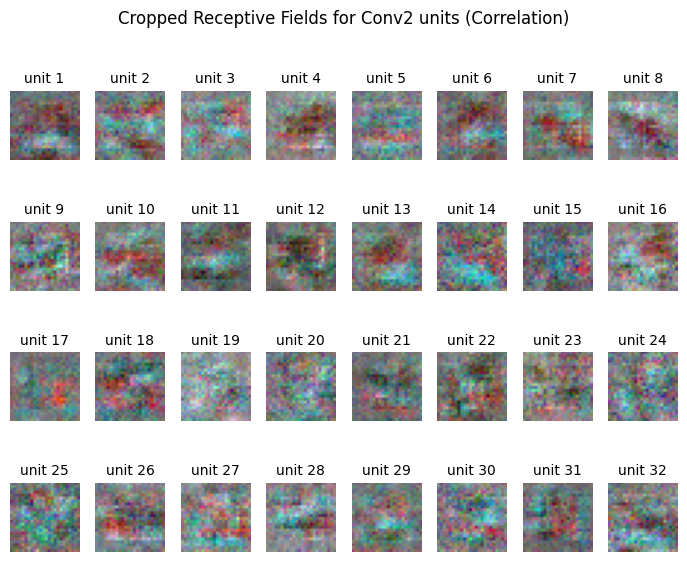

In [115]:
# display cropped RFs
for i in range(rf_cropped2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_cropped2[i]
    
    # if the unit is not dead (positive activation values)
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf2.shape[1], rf2.shape[2], rf2.shape[3])))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Cropped Receptive Fields for Conv2 units (Correlation)')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(7, 6)
plt.show()

# Conv2 - Positive Only [0, 255]

In [ ]:
# load existing data if already recorded
act_conv2 = torch.load('./rwa_data/jaco/jaco_rand/act2.pt')
noise2 = torch.load('./rwa_data/jaco/jaco_rand/noise2.pt')
rf2 = torch.load('./rwa_data/jaco/jaco_rand/rf2.pt')

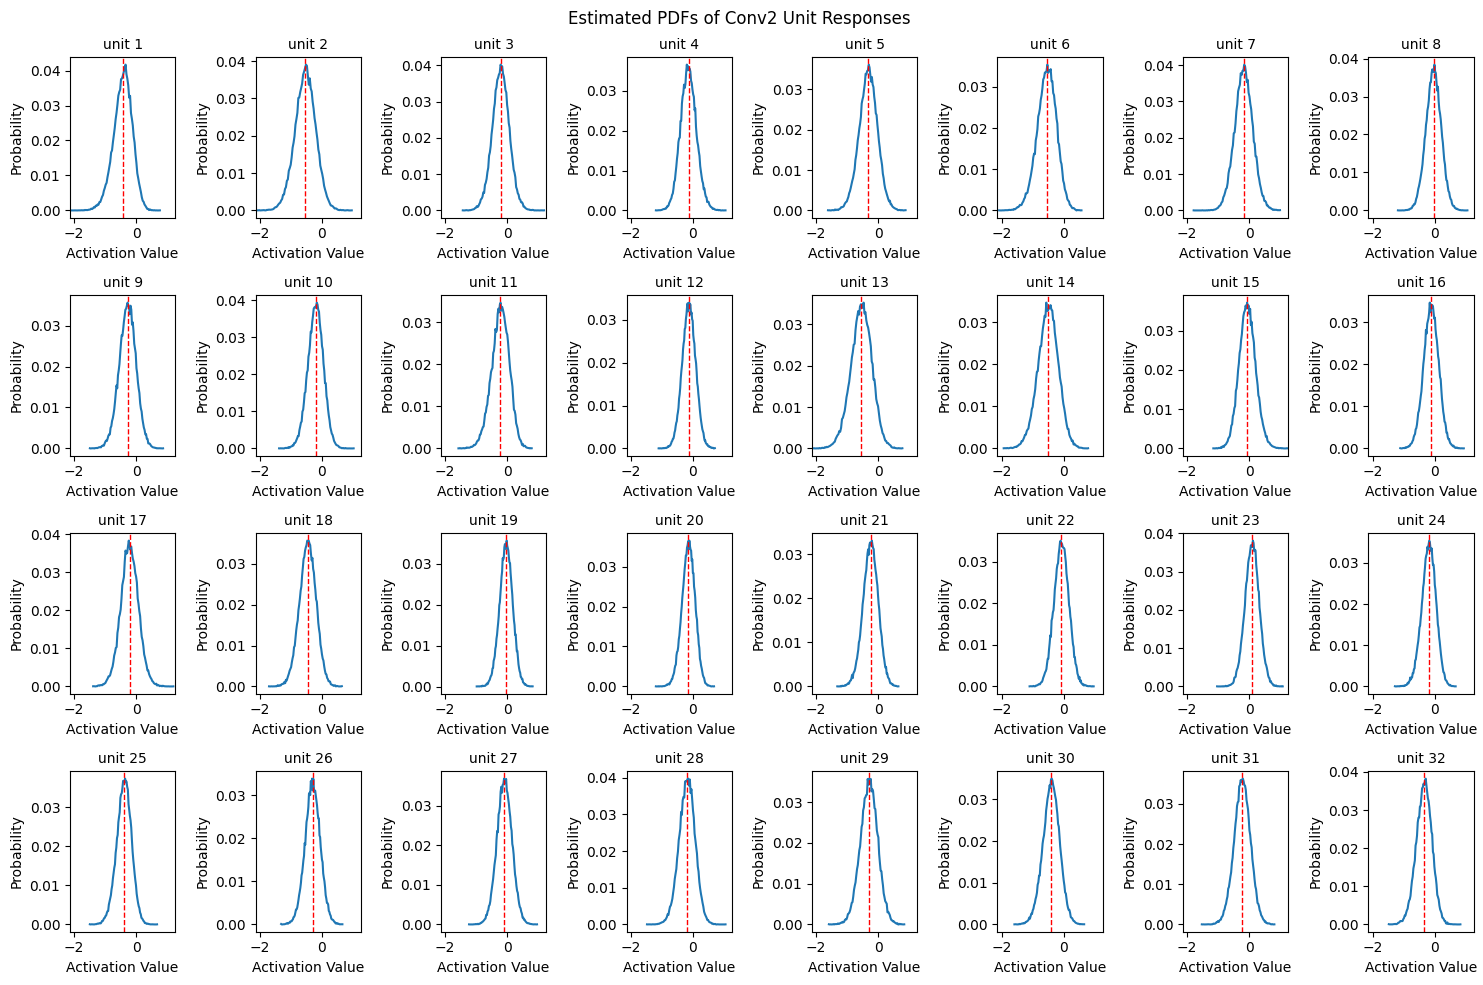

In [39]:
# PDFs of conv2 responses
for i in range(act_conv2.shape[0]):
    plt.subplot(4, 8, i+1)
    plt.xlim(act_conv2.min(), act_conv2.max())
    
    if act_conv2[i][act_conv2[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv2[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf)
        plt.xlabel('Activation Value')
        plt.ylabel('Probability')
        plt.axvline(act_conv2[i].mean(), color='red', linestyle='dashed', linewidth=1)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(14, 10)

plt.suptitle('Estimated PDFs of Conv2 Unit Responses')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 10)
plt.show()

RWA

In [40]:
# RWA
rf2 = RWA(layer, net, act_conv2, noise2, NBatches=NBatches, BSize=BSize)

100%|██████████| 1600000/1600000 [02:41<00:00, 9879.88it/s] 

Shape of receptive field list: torch.Size([32, 64, 64, 3])


In [41]:
# Save the RWA data
torch.save(rf2, './rwa_data/jaco/jaco_rand/rf2.pt')

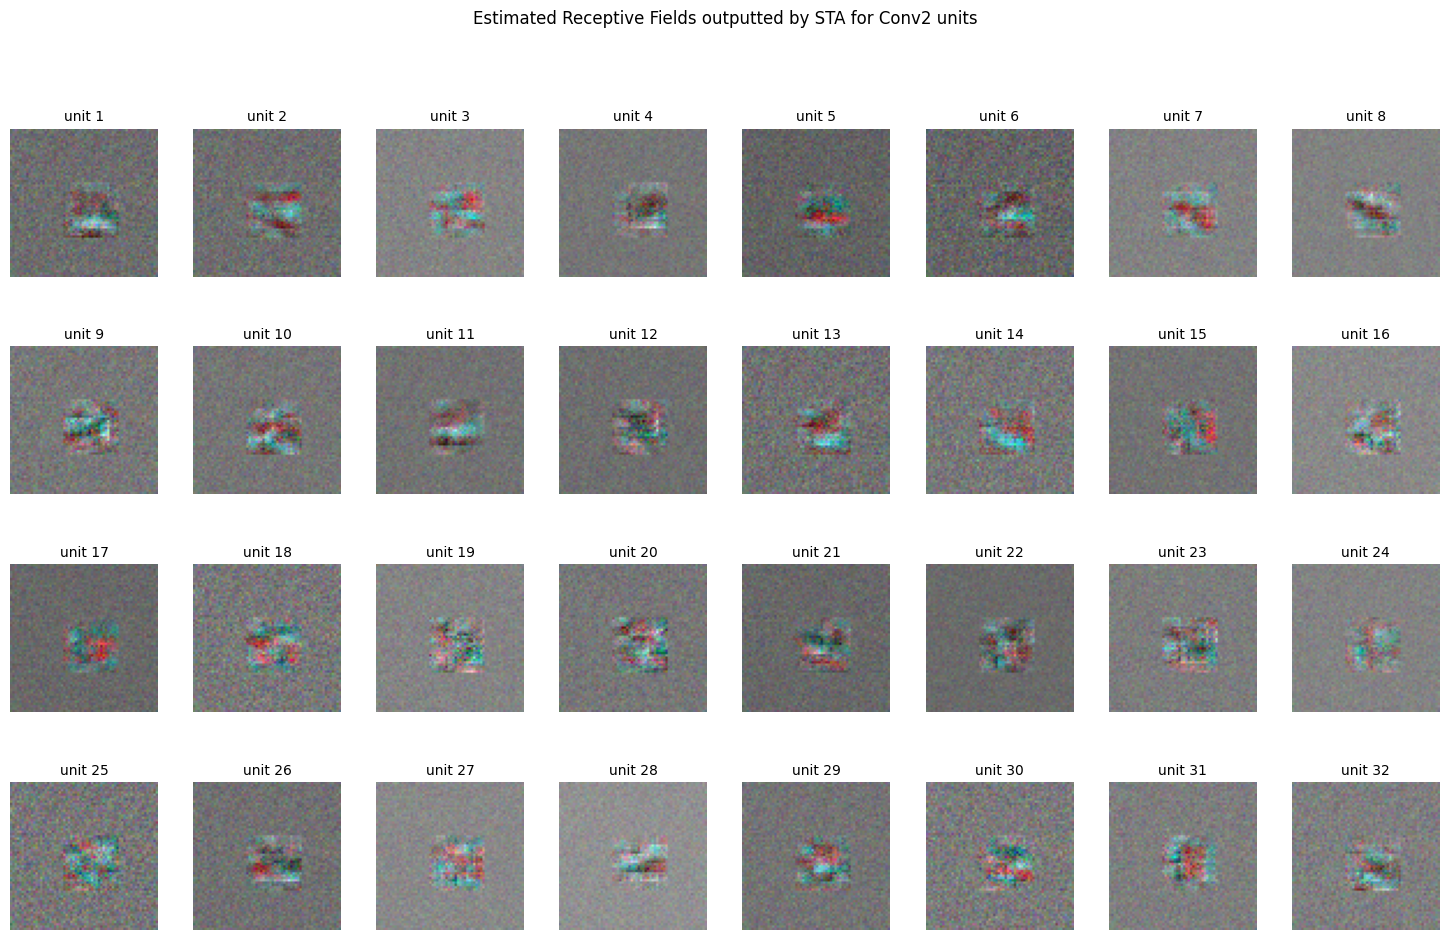

In [42]:
# Visualise the RWA output as image plots
for i in range(rf2.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf2[i]
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0:
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Estimated Receptive Fields outputted by STA for Conv2 units')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 10)
plt.show()